In [1]:
import numpy as np
from numpy import loadtxt
import fitsio
import healpy as hp
import healsparse as hsp
import skyproj
import matplotlib.pyplot as plt
import Config
from astropy.table import Table
import os
from os import listdir

In [2]:
dirStars = '/hdfs/bechtol/balrog/y3/y3a2_gold_v2p2_skim/healpixel/'
dirTrain = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/training/'
files = os.listdir(dirStars)
res = 4096
usedCols = ['HPIX_4096', 'FLAGS_FOREGROUND', 'FLAGS_BADREGIONS', 'FLAGS_FOOTPRINT', 'EXTENDED_CLASS_SOF', 'SOF_PSF_MAG_G', 'SOF_PSF_MAG_R']
numBins = 100

In [3]:
validPix = fitsio.read(dirTrain + 'Valid_4096_Pixels.fits')['PIXEL']

In [4]:
pixCheck = np.full(12*(4096**2), False, dtype = bool)
pixCheck[validPix] = True

In [5]:
PIX = []
FOREGROUND = []
BADREGIONS = []
FOOTPRINT = []
CLASS = []

for file in files:
    starData = fitsio.read(dirStars + file, columns = usedCols)
    FOREGROUND = starData[usedCols[1]]
    BADREGIONS = starData[usedCols[2]]
    FOOTPRINT = starData[usedCols[3]]
    CLASS = starData[usedCols[4]]
    GMAG = starData[usedCols[5]]
    RMAG = starData[usedCols[6]]
    
    cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (CLASS <= 1) & 
                      (CLASS >= 0) & 
                      ((GMAG - RMAG) < 0.5))[0]
    
    allPIX = starData[usedCols[0]][cutIndices]
    
    trimPIX = allPIX[np.where(pixCheck[allPIX])[0]]
    
    PIX.extend(trimPIX)
    
PIX = np.array(PIX)

In [6]:
# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
starPIXRepeats = PIX

# This sorts by the pixel in order to make following methods more efficient.
sortInds = starPIXRepeats.argsort()
starPIXRepeats = starPIXRepeats[sortInds[::1]]
starDETRepeats = np.zeros(len(starPIXRepeats))

# These are indices that will be looping through the pixStar and starPix arrays in parallel.
uniqInd = 0
starInd = 0

# This will be used to store the number of stars at each pixel.
starPIX = np.unique(starPIXRepeats) # The unique pixels, with no repeats.
starDET = np.zeros_like(starPIX)

while starInd < len(starPIXRepeats):
    if starPIX[uniqInd] == starPIXRepeats[starInd]: # If the pixels match up in the arrays.
        starDET[uniqInd] += 1                # Add one for the detection..
        starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.

In [7]:
corrections = fitsio.read(dirTrain + 'Corrections_Map.fits')['SIGNAL']

In [8]:
corrPerPix = np.full(12*(4096**2), -1000.0)
corrPerPix[validPix] = corrections

In [9]:
origStarDET = starDET
starDET = starDET * corrPerPix[starPIX]

In [10]:
origFullMap = np.full(12*(4096**2), hp.UNSEEN)
origFullMap[validPix] = 0
origFullMap[starPIX] = origStarDET

In [11]:
fullMap = np.full(12*(4096**2), hp.UNSEEN)
fullMap[validPix] = 0
fullMap[starPIX] = starDET

In [12]:
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz'
fracData = fitsio.read(fracFile)

In [13]:
fracPix = fracData['PIXEL']
badPix = np.full(12*(4096**2), True, dtype = bool)
badPix[fracPix] = False
fracDet = fracData['SIGNAL']

In [14]:
fullMap[badPix] = hp.UNSEEN
origFullMap[badPix] = hp.UNSEEN

fullMap[fracPix] = fullMap[fracPix] / fracDet
origFullMap[fracPix] = origFullMap[fracPix] / fracDet

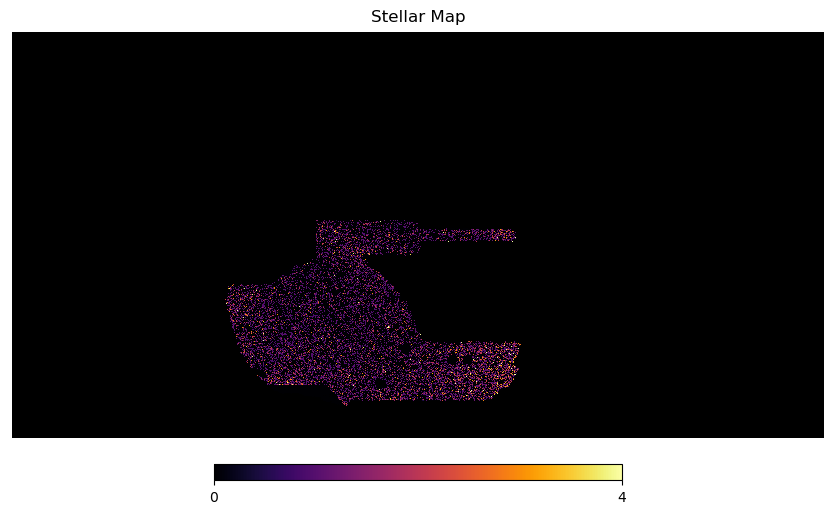

In [15]:
hp.mollview(fullMap, nest=True, title="Stellar Map", min = 0, max = 4, badcolor = 'black', cmap = 'inferno', xsize = 1000)

In [16]:
map512 = 64 * hp.ud_grade(fullMap, 512, order_in = 'NESTED', order_out = 'NESTED')
badPix512 = np.full(12*(4096**2), hp.UNSEEN)
badPix512[validPix] = 1
badPix512 = hp.ud_grade(badPix512, 512, order_in = 'NESTED', order_out = 'NESTED')
badPix512 = np.where(badPix512 < 0)

In [17]:
map512[badPix512] = hp.UNSEEN
map512[np.where(map512 == 0)[0]] = hp.UNSEEN

In [18]:
origMap512 = 64 * hp.ud_grade(origFullMap, 512, order_in = 'NESTED', order_out = 'NESTED')
badPix512 = np.full(12*(4096**2), hp.UNSEEN)
badPix512[validPix] = 1
badPix512 = hp.ud_grade(badPix512, 512, order_in = 'NESTED', order_out = 'NESTED')
badPix512 = np.where(badPix512 < 0)

In [19]:
origMap512[badPix512] = hp.UNSEEN
origMap512[np.where(origMap512 == 0)[0]] = hp.UNSEEN

In [20]:
nside_coverage = 32
hspMap512 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=map512)
origHspMap512 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=origMap512)
hspMap4096 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullMap)

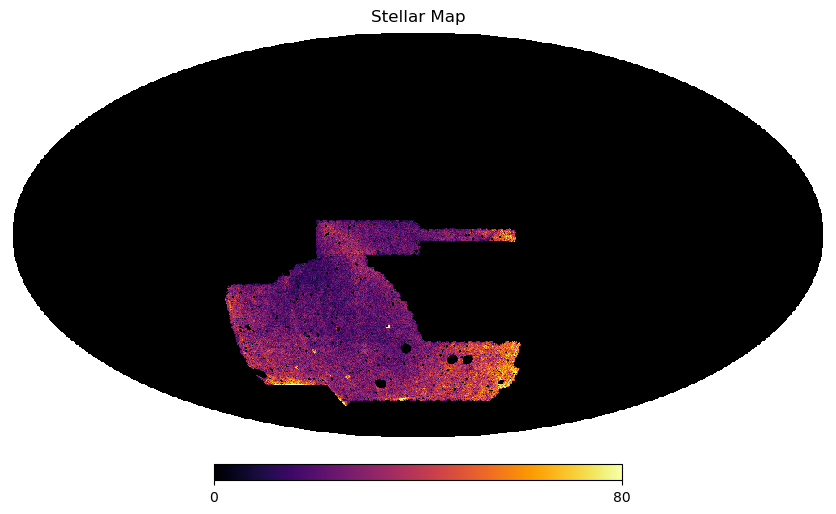

In [21]:
hp.mollview(map512, nest=True, title="Stellar Map", min = 0, max = 80, badcolor = 'black', cmap = 'inferno', xsize = 1000)

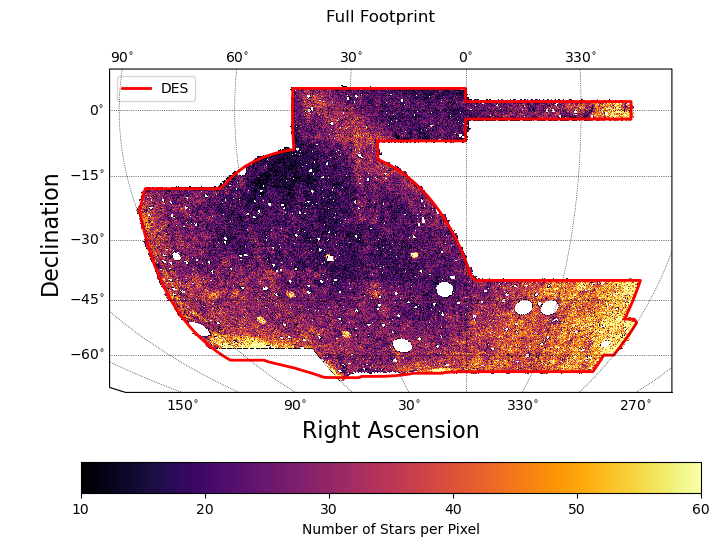

In [22]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_des(label='DES')
sp.draw_hspmap(hspMap512, cmap = 'inferno')
plt.clim(10, 60)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Full Footprint')
sp.legend()
plt.show()

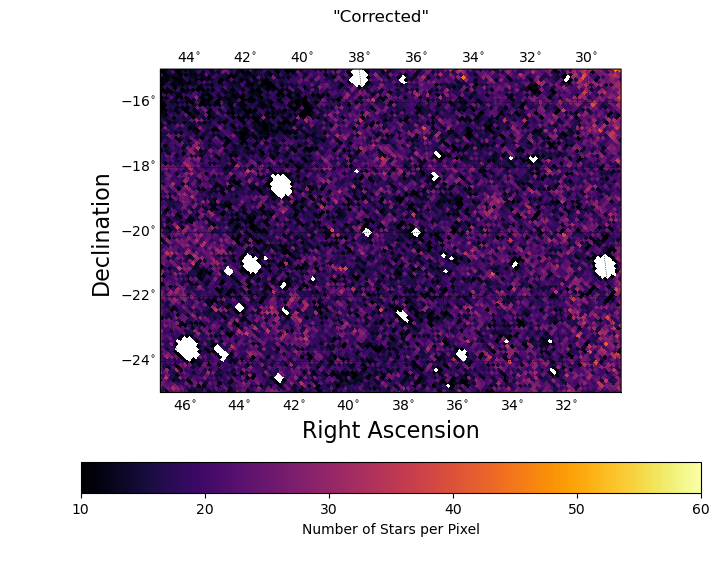

In [33]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
sp.draw_hspmap(hspMap512, cmap = 'inferno')
sp.set_extent([30, 45, -25, -15])
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
plt.clim(10, 60)
fig.suptitle('\"Corrected\"')
plt.show()

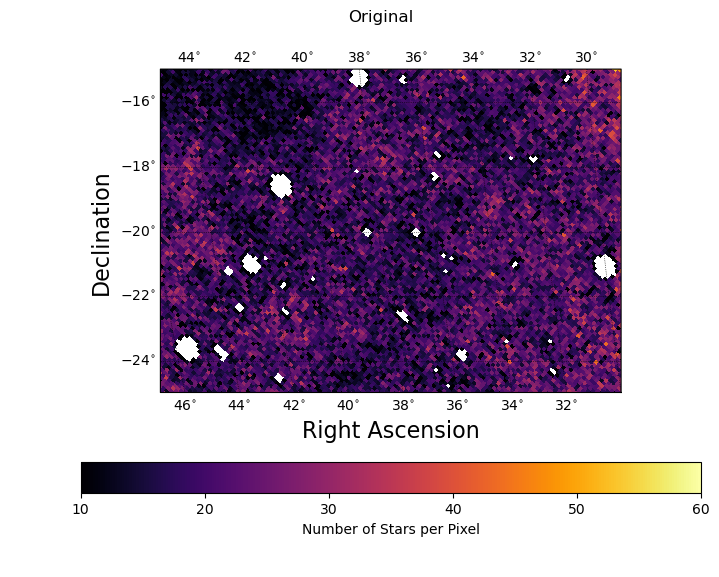

In [32]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
sp.draw_hspmap(origHspMap512, cmap = 'inferno')
sp.set_extent([30, 45, -25, -15])
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
plt.clim(10, 60)
fig.suptitle('Original')
plt.show()

In [25]:
RACheck, DECCheck = hp.pix2ang(512, np.arange(12 * (512**2)), nest = True, lonlat = True)

In [34]:
RALim = [30, 45]
DECLim = [-25, -15]

In [35]:
PIXCheck = np.where((RACheck <= RALim[1]) & (RACheck >= RALim[0]) & (DECCheck <= DECLim[1]) & (DECCheck >= DECLim[0]))[0]

In [36]:
corrSTD = np.std(hspMap512[PIXCheck][np.where((hspMap512[PIXCheck] >= 0) & (hspMap512[PIXCheck] <= 40))[0]])

In [37]:
origSTD = np.std(origHspMap512[PIXCheck][np.where((origHspMap512[PIXCheck] >= 0) & (origHspMap512[PIXCheck] <= 40))[0]])

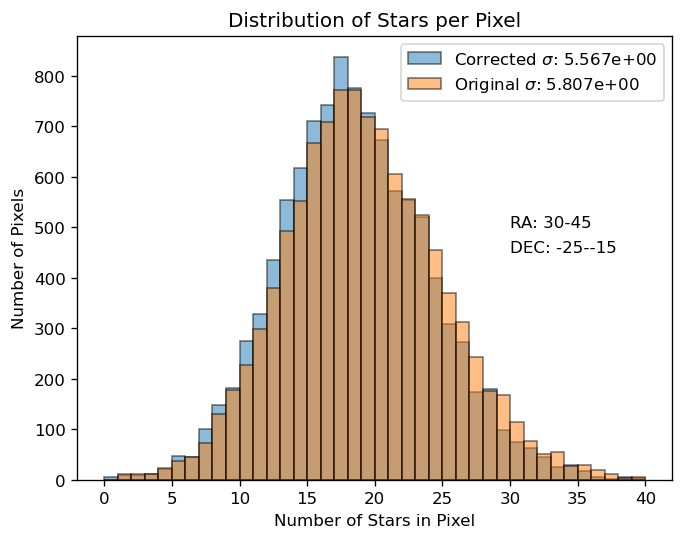

In [49]:
plt.figure(dpi = 120)
plt.hist(hspMap512[PIXCheck], bins = np.linspace(0, 40, 41), alpha = 0.5, edgecolor = 'black', linewidth = 1, label = 'Corrected ' + r'$\sigma$' + ': ' + str(np.format_float_scientific(corrSTD, precision = 3)))
plt.hist(origHspMap512[PIXCheck], bins = np.linspace(0, 40, 41), alpha = 0.5, edgecolor = 'black', linewidth = 1, label = 'Original ' + r'$\sigma$' + ': ' + str(np.format_float_scientific(origSTD, precision = 3)))
plt.legend()
plt.title('Distribution of Stars per Pixel')
plt.ylabel('Number of Pixels')
plt.xlabel('Number of Stars in Pixel')
plt.text(30, 500, 'RA: ' + str(RALim[0]) + '-' + str(RALim[1]))
plt.text(30, 450, 'DEC: ' + str(DECLim[0]) + '-' + str(DECLim[1]))
plt.show()